#### Imports

In [17]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt

#### Helper functions

# A more complicated function

$$ M = 6, N = 10, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) - 1 \\
    10\cos(-2x_2 + 1) + 3 \\
    2 \exp((x_3 + 10) / ||x||_2) \\
    \exp(\sin(\pi/2 + ||x||_2)) - 10 \\
    \left(\ln\left(3 + \left|\sum_{i=1}^{M} x_i\right|\right) - 1\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    5\left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 + 1\\
    \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    ||x||_2^2 - 5 \\
    |\sum_{i=1}^M x_i| - 1
\end{bmatrix}$$

In [19]:
M = 6

F1 = compose(proj(M)(0), sin + compose(mul_const(2), cos)) - constM(M)(1)
F2 = compose(proj(M)(1), mul_const(-2) + const1(1), const1(10) * cos) + constM(M)(3)
F3 = compose((proj(M)(2) + constM(M)(10)) / norm_sqr(M), 2 * exp)
F4 = compose(norm_sqr(M) + constM(M)(np.pi / 2), sin, exp) - constM(M)(10)
F5 = compose(compose(sum_(M), abs) + constM(M)(3), log - const1(1), square)
F6 = compose(proj(M)(4), sin, square, exp, cos)
F7 = compose(sum_(M), sqrt - const1(1), sin, const1(5) * square) + constM(M)(1)
F8 = compose(proj(M)(5), sin, exp, cos, const1(2) - const1(5) * sqrt)
F9 = norm_sqr(M) - constM(M)(5)
F10 = compose(sum_(M), abs) - constM(M)(1)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10)

# Performance tests

Levenberg-Marquardt:   0%|          | 0/500 [00:00<?, ?it/s]

Gradient descent: 100%|██████████| 500/500 [00:01<00:00, 487.01it/s]


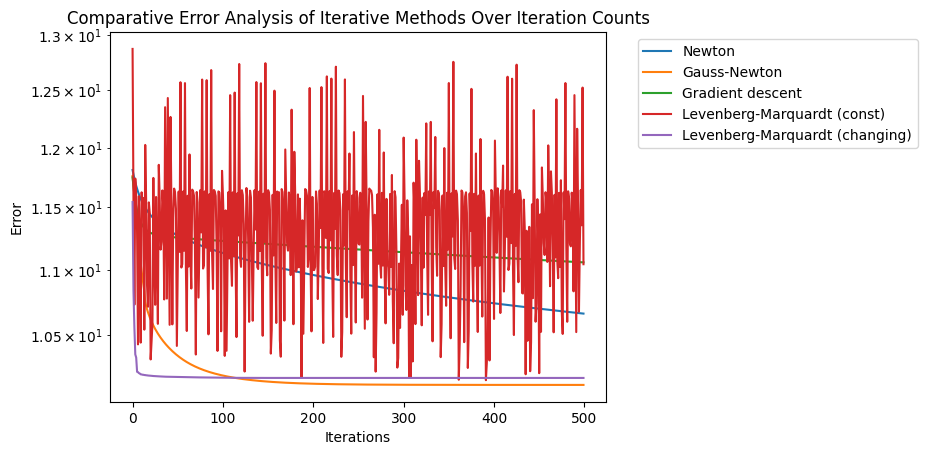

In [20]:
max_iter = 500
p0 = np.random.randn(M)
alpha_gd = 1e-4
alpha_gn = 1e-2
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []
errors_newton = []
log_interval = 1

optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_const_param, log_interval=log_interval)

optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_modifying_param, log_interval=log_interval)

gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter, errs=errors_gauss_newton, log_interval=log_interval)
newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, errs=errors_newton, log_interval=log_interval)
gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter, errs=errors_gradient_descent, log_interval=log_interval)

iters = np.arange(0, max_iter, log_interval)
for err, label in [
    (errors_newton, "Newton"),
    (errors_gauss_newton, "Gauss-Newton"),
    (errors_gradient_descent, "Gradient descent"),
    (errors_levenberg_marquardt_const_param, "Levenberg-Marquardt (const)"),
    (errors_levenberg_marquardt_modifying_param, "Levenberg-Marquardt (changing)"),
]:
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()